# Model Optimization I:
## Feature Selection and Dimensionality Reduction

- Principal component analysis
- Dimensionality reduction
- Stepwise feature selection
- Resampling unbalanced data
#### recap:
- Scaling and encoding


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Dimensionality Reduction

#### Why It's Important:
- __Prevent Overfitting:__ Too many features can cause your model to overfit. By removing less important features, you can boost your model's performance and generalization ability.
- __Reduce Variance:__ Having a lot of features increases the model's variance, making it more sensitive to noise in the data.
- __Simplify Interpretation:__ It's much easier to understand and visualize data when you have fewer features.

### Strategies for dimensionality reduction:

#### 1. Remove Obviously Useless Features:

- __Collinearity:__ If two features have a correlation coefficient of 1.0, drop one of them.
- __Interdependent Features:__ From a group of features that are closely related, keep only one. For example, if you include a logarithmically transformed feature, remove the original.
- __High-Cardinality Columns:__ Remove categorical columns with many unique values (like UserID), especially if each row has a unique value.
- __Zero-Variance Features:__ Get rid of numerical and categorical features that have only one unique value.

#### 2. Use Domain expertise to decide which features to remove:

- bmi, height, weight
- GDP, GDP per capita, population
- age, date of bifth

#### 3. Feature selection techniques:

- Remove low-variance features (use with caution and note that PCA takes care of low-variance and collinear features)
- Select features based on a statistical test (`sklearn.sklearn.feature_selection.SelectKBest`)
- Recursive feature elimination (based on model coefficient or featrure importance)
- Feature selection based on regularization (we will discuss this later)
- Stepwise feature selection

#### 4. Feature dimensionality reduction:

- Algebra based methods: PCA, matrix factorization
- Deep learning methods: embeddings, autoencoders

## PCA - Principal Component Analysis


PCA (Principal Component Analysis) is a technique that transforms features using a mathematical method called eigen decomposition. While it isn't a machine learning algorithm, PCA sets the stage for more advanced feature extraction methods, like autoencoders, which are unsupervised learning algorithms.

PCA helps to remove features based on their contribution to the total variance in the dataset.

**Pros:**
- Efficiently reduces dimensionality.
- Eliminates collinearity.
- Removes low-variance features.

**Cons:**
- Principal components can be hard to interpret. For example, a principal component might be 20% Gender, 45% Salary, and 35% Education.
- PCA focuses only on the feature set and isn't tailored to any specific machine learning algorithm, unlike other model selection techniques.

### Example: Iris Dataset

#### In the lab, you will perform PCA on domain-relevant data

In [2]:
# import Iris from sklearn.datasets
from sklearn.datasets import load_iris
data = load_iris()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
X = data['data']
features = data['feature_names']
y = data['target']
df_iris = pd.DataFrame(X, columns = features)
df_iris['species'] = y
df_iris['species'] =df_iris['species'].map(dict(pd.Series(data['target_names'])))

In [4]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


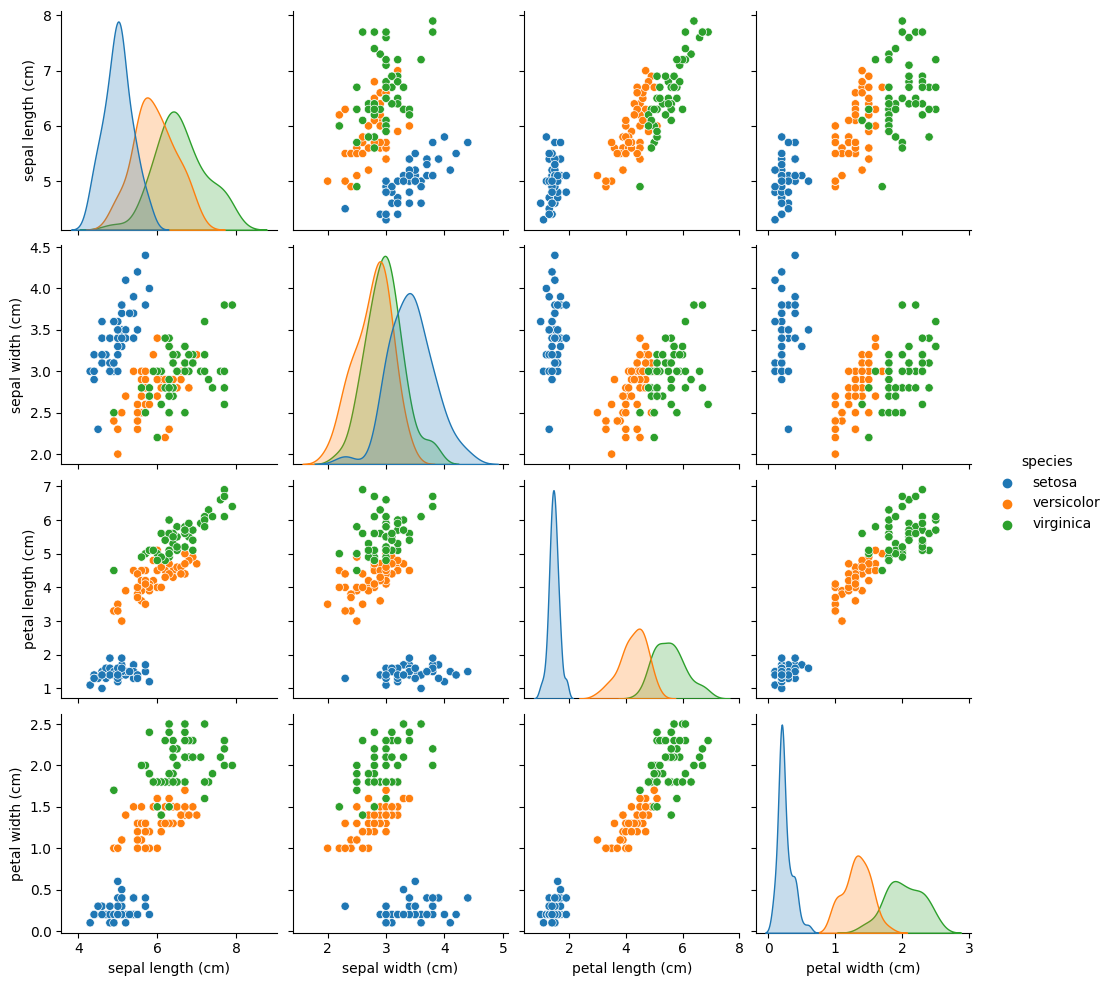

In [5]:
sns.pairplot(data = df_iris, hue = 'species');

__PCA requires feature scaling__

In [6]:
sc = StandardScaler()  ## you can also use the MinMax scaler
X = sc.fit_transform(X)

- To perform eigendecomposition, start with the covariance matrix

In [7]:
np.cov(X.T)

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

The covariance between two features is calculated as follows:

$$Cov(𝑋, 𝑌 ) = \frac{\sum(x_i - \bar{x}) (y_i - \bar{y})}{N-1}$$

In [8]:
cov_mat = np.cov(X.T)
print("Covariance matrix:\n", cov_mat)
eig_vals, eig_vecs = np.linalg.eig(cov_mat) ## these are the eigen vectors and values
print("Eigenvalues: \n", eig_vals)
print("Eigenvectors: \n",eig_vecs)


Covariance matrix:
 [[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]
Eigenvalues: 
 [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors: 
 [[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


- __Good news:__ you don't need to perform eigen decomposition manually
- PCA is fully implemented as an object class in sklearn: fit PCA on the original features _X_, transform into an array of principal components

#### Continue with the Iris example:
- Let's make our first example 2-dimensional for better visualzation: let's look at just two variables, petal length vs width:

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_new = pca.fit_transform(X[:, 2:])
## as before, fit_transform is a shorthand for pca.fit(X); pca.trandform(X)
## generally, you may need to fit pca on one feature set (such as X_train)
## and then use it to transform another feature set (e.g., X_test)

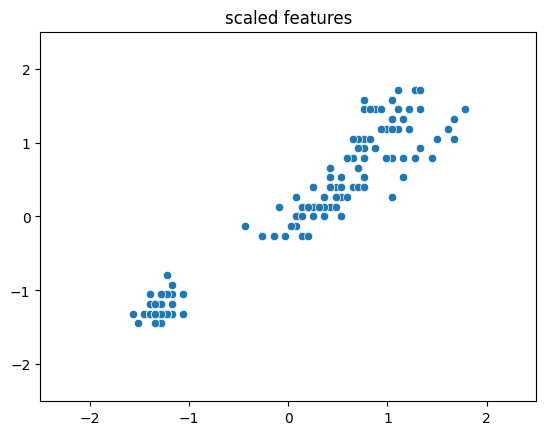

In [10]:
## plot the original scaled features:
ax = sns.scatterplot(x = X[:, 2], y = X[:, 3])
ax.set_xlim((-2.5, 2.5))
ax.set_ylim((-2.5, 2.5))
ax.set_title('scaled features');

In [11]:
## both features have a significant variance:

X[:, 2:].var(axis = 0)

array([1., 1.])

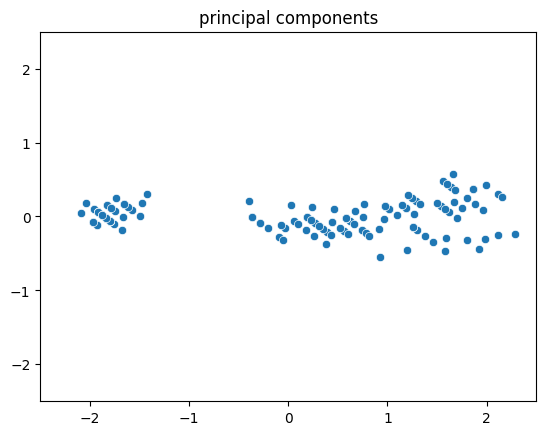

In [12]:
ax = sns.scatterplot(x = X_new[:,0], y = X_new[:,1])
ax.set_xlim((-2.5, 2.5))
ax.set_ylim((-2.5, 2.5))
ax.set_title('principal components');

In [13]:
##### PC0 has much higher variance than PC1 

X_new.var(axis = 0)

array([1.96286543, 0.03713457])

In [14]:
pca.explained_variance_ratio_
## principal components can be ranked by explained variance
## lower-variance PCs can be discarded

array([0.98143272, 0.01856728])

In [15]:
## now let's perform PCA with al 4 numerical features
pca = PCA(n_components=4) ## how many PCs do we need?
X_pc = pca.fit_transform(X)
pd.Series(pca.explained_variance_ratio_)

0    0.729624
1    0.228508
2    0.036689
3    0.005179
dtype: float64

- Lets plot the cumulative explained variance for the principal components

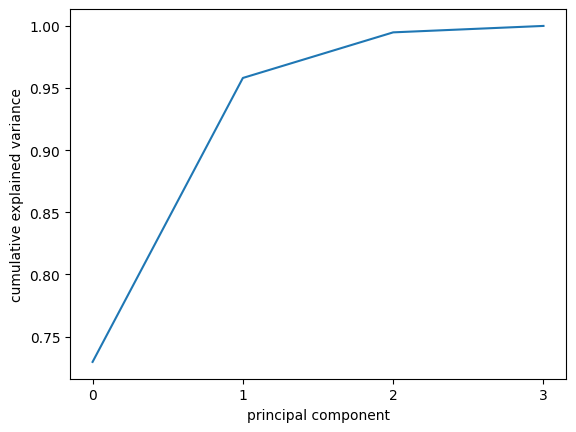

In [16]:
ax = sns.lineplot(y = np.cumsum(pca.explained_variance_ratio_), x = ['0', '1', '2', '3'])
ax.set_xlabel('principal component')
ax.set_ylabel('cumulative explained variance');

In [17]:
#to transform principal compoents back to the original data dimensions use:
X_inverse = pca.inverse_transform(X_pc)

#np.round(X_inverse - X, decimals = 6) == 0

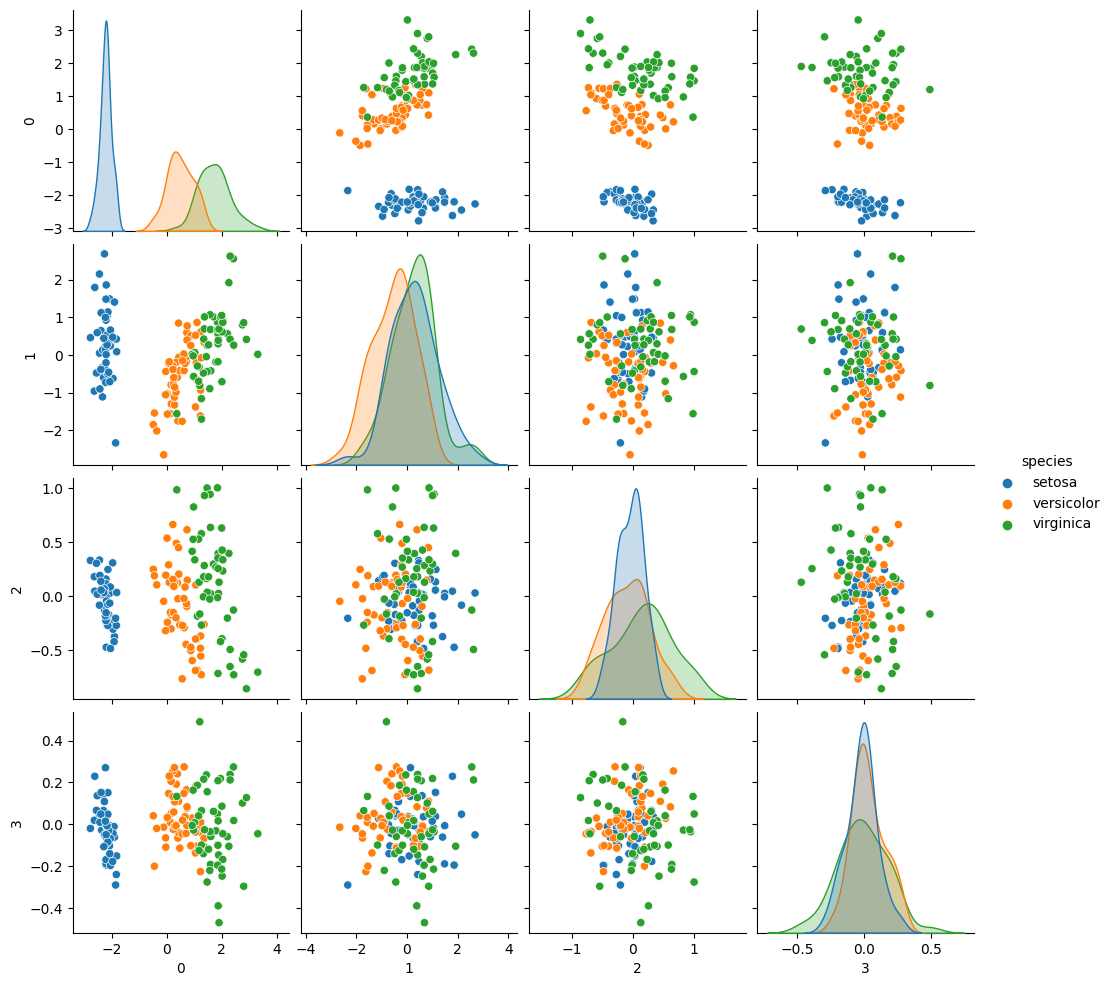

In [18]:
df_pc = pd.DataFrame(X_pc)
df_pc['species'] = df_iris['species']
sns.pairplot(data = df_pc, hue = 'species');

In [19]:
## now let's see how many PCs we need to train a good model
## original features
lr1 = LogisticRegression()
lr1.fit(X, y)
print('accuracy', accuracy_score(lr1.predict(X), y))
confusion_matrix(lr1.predict(X), y)

accuracy 0.9733333333333334


array([[50,  0,  0],
       [ 0, 47,  1],
       [ 0,  3, 49]], dtype=int64)

In [20]:
## PCA transformed features

pca = PCA(n_components=1) ## vary Number of PC from 4 to 1 => observe the Confusion Matrix
X_pc = pca.fit_transform(X)
lr2 = LogisticRegression()
lr2.fit(X_pc, y)
print('accuracy', accuracy_score(lr2.predict(X_pc), y))
confusion_matrix(lr2.predict(X_pc), y)

accuracy 0.9266666666666666


array([[50,  0,  0],
       [ 0, 44,  5],
       [ 0,  6, 45]], dtype=int64)

## Feature Selection Techniques

## Example: Loan Eligible Data
https://www.kaggle.com/datasets/vikasukani/loan-eligible-dataset

#### Data Dictionary 
    Loan_ID	= Unique Loan ID
    Gender = Male/ Female
    Married	= Applicant married (Y/N)
    Dependents = Number of dependents
    Education = Applicant Education (Graduate/ Under Graduate)
    Self_Employed = Self-employed (Y/N)
    ApplicantIncome = Applicant income
    CoapplicantIncome = Coapplicant income
    LoanAmount = Loan amount in thousands
    Loan_Amount_Term = Term of a loan in months
    Credit_History = credit history meets guidelines
    Property_Area = Urban/ Semi-Urban/ Rural
    Loan_Status = Loan approved (Y/N)

In [21]:
df = pd.read_csv('../data/loan_eligibility.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Data types and missing values

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


#### Impute missing values

In [23]:
df.fillna(method = 'ffill', inplace=True)
df.fillna(method = 'bfill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


#### Label Encoding. Note: labels do not need one-hot encoding even if multinomial

In [24]:
le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

#### Categorical Feature Encoding

- Express categorical features as sparse vectors of "0" and "1" using one-hot encoding
- Remember: the numbeer of sparse one-hot vectors is `Cardinality - 1`
- `pd.get_dummies(df, drop_first=True )` will take care of all `'object'` columns
- Make sure that you remove "useless" high-cardinality string columns such as `"UserID"`prior to one-hot encoding

In [25]:
df.drop(columns = 'Loan_ID', inplace = True)

##### Hidden categorical variables: convert to "str" type so that pd.get_dummies() will one-hot encode these columns

In [26]:
df['Credit_History'].value_counts()

1.0    513
0.0    101
Name: Credit_History, dtype: int64

In [27]:
df['Credit_History'] = df['Credit_History'].astype('str')

In [28]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,128.0,360.0,1,1,0,0,0,0,0,0,1,0,1
1,4583,1508.0,128.0,360.0,0,1,1,1,0,0,0,0,1,0,0
2,3000,0.0,66.0,360.0,1,1,1,0,0,0,0,1,1,0,1
3,2583,2358.0,120.0,360.0,1,1,1,0,0,0,1,0,1,0,1
4,6000,0.0,141.0,360.0,1,1,0,0,0,0,0,0,1,0,1


#### Get your data ready for modeling

In [29]:
label = 'Loan_Status'
features = list(df.columns)
features.remove(label)
print(features)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Credit_History_1.0', 'Property_Area_Semiurban', 'Property_Area_Urban']


In [30]:
## build data arrays

X = df[features].to_numpy()
y = df[label].to_numpy()
print(X.shape, y.shape)

(614, 14) (614,)


In [31]:
## train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [32]:
print(X_train.shape, X_test.shape)

(429, 14) (185, 14)


#### Numerical Feature Scaling

In [33]:
scaler = MinMaxScaler()
## fit the scaler: 
## remember: if train-test split is involved, always fit the scaler on the Training set
## transform the fit scaler on any data that need to be scaled
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


##### Optional: Compute Feature Variance and eliminate features with var = 0

In [34]:
pd.Series(X_train.var(axis= 0), index = features)

ApplicantIncome            0.005512
CoapplicantIncome          0.006193
LoanAmount                 0.017012
Loan_Amount_Term           0.021965
Gender_Male                0.160280
Married_Yes                0.235024
Dependents_1               0.142740
Dependents_2               0.133383
Dependents_3+              0.074929
Education_Not Graduate     0.172407
Self_Employed_Yes          0.121973
Credit_History_1.0         0.133383
Property_Area_Semiurban    0.236686
Property_Area_Urban        0.222994
dtype: float64

## Stepwise model selection

In [35]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)[:220]))
print(log_loss(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61        65
           1       0.77      0.97      0.86       120

    accuracy                           0.79       185
   macro avg       0.84      0.72      0.74       185
weighted avg       0.82      0.79      0.77       185

7.094602642792773


In [36]:
## Step 1. Train a LR model on each feature one at a time,
## select only one feature which gives us the best (lowest) MSE
#features_remaining = set(range(X_train.shape[1]))
features_retained = []

ll = []

for col in range(X_train.shape[1]):
    lr = LogisticRegression()
    lr.fit(X_train[:,[col]], y_train)
    ll.append(log_loss(y_test, lr.predict(X_test[:,[col]])))
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(np.array(ll).argmin())
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(11, 7.094602642792773)
[11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


In [37]:
## Step 2. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    lr = LogisticRegression()
    lr.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, lr.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(0, 7.094602642792773)
[11, 0] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


In [38]:
ll## Step 3. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    lr = LogisticRegression()
    lr.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, lr.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(0, 7.094602642792773)
[11, 0, 1] [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


##### Continue...... until MSE stops improving (within a set tolerance)

##### Note that Step-wise feature selection is gready: there is no guarantee that the most optimal feature set will need to contain the feature from Step 2

In [39]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(classification_report(y_test, knn.predict(X_test)[:220]))
print(log_loss(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.40      0.51        65
           1       0.74      0.92      0.82       120

    accuracy                           0.74       185
   macro avg       0.73      0.66      0.67       185
weighted avg       0.73      0.74      0.71       185

9.148276906218385


In [40]:
features_retained = []

ll = []

for col in range(X_train.shape[1]):
    knn = KNeighborsClassifier()
    knn.fit(X_train[:,[col]], y_train)
    ll.append(log_loss(y_test, knn.predict(X_test[:,[col]])))
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(np.array(ll).argmin())
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(11, 7.094602642792773)
[11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


In [41]:
## Step 2. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    knn = KNeighborsClassifier()
    knn.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, knn.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(1, 7.094602642792773)
[11, 1] [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


In [42]:
## Step 3. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    knn = KNeighborsClassifier()
    knn.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, knn.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(5, 6.907897909875091)
[11, 1, 6] [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13]


In [43]:
## Step 4. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    knn = KNeighborsClassifier()
    knn.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, knn.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(7, 6.721201821253952)
[11, 1, 6, 9] [0, 2, 3, 4, 5, 7, 8, 10, 12, 13]


In [44]:
## Step 5. 

ll = []

for col in list(features_remaining):
    #print(col)
    fr = features_retained.copy()
    fr.append(col)
    #print(fr)
    knn = KNeighborsClassifier()
    knn.fit(X_train[:,fr], y_train)
    #print(lr.coef_)
    modscore= log_loss(y_test, knn.predict(X_test[:,fr]))
    #print(modscore)
    ll.append(modscore)
print((np.array(ll).argmin(), np.array(ll).min()))

features_retained.append(features_remaining[np.array(ll).argmin()])
features_remaining = list(set(range(X_train.shape[1])) - set(features_retained))

print(features_retained, features_remaining)

(3, 6.721201821253952)
[11, 1, 6, 9, 4] [0, 2, 3, 5, 7, 8, 10, 12, 13]


In [45]:
lr = LogisticRegression()
lr.fit(X_train[:, [11]], y_train)
print(classification_report(y_test, lr.predict(X_test[:, [11]])[:220]))
print(log_loss(y_test, lr.predict(X_test[:, [11]])))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61        65
           1       0.77      0.97      0.86       120

    accuracy                           0.79       185
   macro avg       0.84      0.72      0.74       185
weighted avg       0.82      0.79      0.77       185

7.094602642792773


### Select K Best:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

select = SelectKBest(f_classif, k=4)#X_train.shape[1])
select.fit(X_train, y_train)
#X_new = SelectKBest(f_classif, k=X_train.shape[1]).fit_transform(X_train, y_train)


SelectKBest(k=4)

In [47]:
pd.DataFrame({'features': features, 'scores':select.scores_, 'pval':select.pvalues_, 'select':select.pvalues_<0.05})

,features,scores,pval,select
0,ApplicantIncome,0.314260,5.753718e-01,False
1,CoapplicantIncome,0.073935,7.858222e-01,False
2,LoanAmount,0.160000,6.893562e-01,False
3,Loan_Amount_Term,0.004272,9.479180e-01,False
4,Gender_Male,0.147953,7.006908e-01,False
5,Married_Yes,3.908296,4.869116e-02,True
6,Dependents_1,2.032932,1.546541e-01,False
7,Dependents_2,0.379209,5.383548e-01,False
8,Dependents_3+,0.830071,3.627660e-01,False
9,Education_Not Graduate,1.541115,2.151334e-01,False


### Recap: Feature Scaling

##### Min Max Scaler Pros:

- Scales numerical features to the same scale as one-hot categorical (0, 1)

##### Min Max Scaler Cons:

- If a feature has outliers, the entire range is fitted between 0 and 1, and the main population can be squeezed into a small range

##### Standard Scaler
- can be a better choice for a feature with outliers

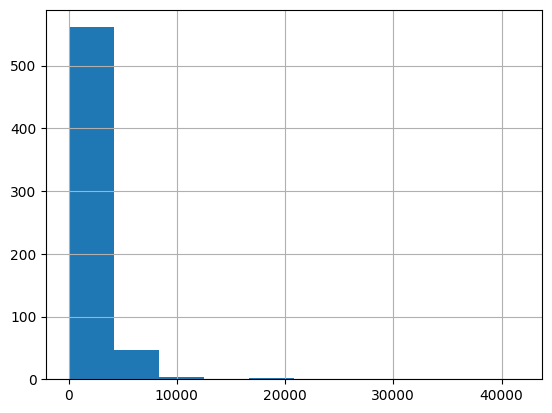

In [48]:
df['CoapplicantIncome'].hist();

In [49]:
sc1 = MinMaxScaler()
sc2 = StandardScaler()
X_scaled = pd.DataFrame({'MinMax' : sc1.fit_transform(df[['CoapplicantIncome']])[:,0], 
                         'Standard':sc2.fit_transform(df[['CoapplicantIncome']])[:,0]})

In [50]:
X_scaled.var()

MinMax      0.004932
Standard    1.001631
dtype: float64

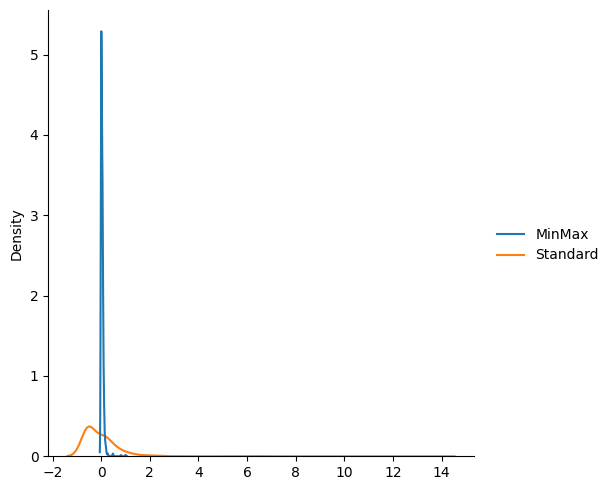

In [51]:
ax = sns.displot(X_scaled, kind = 'kde');

## Resampling unbalanced data

https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/

In [52]:
fraud_df = pd.read_csv('../data/Fraud_Detection_kaggle.csv')

In [53]:
fraud_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

#### Oversampling the minority class:
- Create duplicated rows from the minority class example to artificially increase the number of examples to a desired values (i.e., close to the number of majority class examples)

In [54]:
### oversample the inferior class 

oversample = fraud_df[fraud_df['fraud'] == 1].sample(n = (fraud_df['fraud'] == 0).sum(), replace = True)

fraud_oversampled = pd.concat([fraud_df[fraud_df['fraud'] == 0], oversample])
fraud_oversampled['fraud'].value_counts()

0    587443
1    587443
Name: fraud, dtype: int64

In [55]:
### Let's compare classifier peformance on the orginal imbalanced dataset...:
X = fraud_df[['amount']]
y = fraud_df['fraud']
lr = LogisticRegression()
lr.fit(X, y)
print(classification_report(y, lr.predict(X))[:220])

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    587443
           1       0.87      0.56      0.68      7200

    accuracy                           0.99    594643
  


In [56]:
## .. and the oversampled dataset. What is happening to Recall on Fraud = 1?
X = fraud_oversampled[['amount']]
y = fraud_oversampled['fraud']
lr = LogisticRegression()
lr.fit(X, y)
print(classification_report(y, lr.predict(X))[:220])

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    587443
           1       0.97      0.85      0.91    587443

    accuracy                           0.91   1174886
  


In [57]:
_, _, Y_train, Y_test = train_test_split(X, y, stratify = y)

In [58]:
pd.Series(Y_test).value_counts(normalize = True)

1    0.5
0    0.5
Name: fraud, dtype: float64

In [59]:
pd.Series(Y_train).value_counts(normalize = True)

1    0.5
0    0.5
Name: fraud, dtype: float64

In [60]:
fraud_df['fraud'].value_counts(normalize = True)

0    0.987892
1    0.012108
Name: fraud, dtype: float64